In [ ]:
# monter le google drive pour qu'il soit accessible ("Fichiers" dans colab - liste à gauche)

from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installation des librairies pas implémentées par défaut
%pip install optuna
%pip install shap
%pip install tpot

In [ ]:
# Importation des librairies nécessaires

import optuna
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    recall_score,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
)
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import xgboost as xgb
from tpot import TPOTClassifier


from joblib import dump, load


# Option à modifier pour visualiser la totalité des colonnes

pd.set_option("display.max_columns", None)

In [ ]:
def Create_Index(df):
    # paramètres généraux
    tts_test_size = 0.2    # définir la proportion du nombre d'incidents à affecter au jeu de test
    np.random.seed(42)     # fixer le caractère aléatoire (même base + même seed => donnera la même liste)
    # Faire la liste des incidents et la trier
    tts_inc_list = df['IncidentNumber'].unique().tolist()
    tts_inc_list.sort()
    # Total des véhicules et incidents pour juger de la répartition train / test
    tts_nb_pump = df.shape[0]
    tts_nb_inc = len(tts_inc_list)
    # Taille de la liste des incidents à mettre en jeu de test
    tts_test_size_nb = np.int64(tts_nb_inc * tts_test_size)
    # liste des n° d'incidents à garder dans le jeu de test = sélectionner 'test_size_nb' éléments de la liste, par un tirage sans remise
    tts_inc_test_list = list(np.random.choice(tts_inc_list, tts_test_size_nb, replace= False))
    # sauvegarder les index des lignes des incidents que l'on affectera en test et train
    # car nous allons ensuite supprimer la variable 'IncidentNumber'
    tts_index_test = df[df['IncidentNumber'].isin(tts_inc_test_list)].index
    tts_index_train = df[~df['IncidentNumber'].isin(tts_inc_test_list)].index
    return tts_index_test,tts_index_train

# fonction créant la variable binaire cible
def Create_Goal(df):
    conditions = [
        (df["AttendanceTimeSeconds"] > 360),
        (df["AttendanceTimeSeconds"] <= 360),
    ]
    choices = [1, 0]
    df["Goal"] = np.select(conditions, choices)

def To_num(df):
    df.workingday=df.workingday.astype('int64')
    df.school_holidays=df.school_holidays.astype('int64')
    return df

# fonction selectionnant les features et la target dans le dataframe
def Select_Column(df):
    return df[
        [
         'DeployedFromLocation',
         'Appliance',
         'PropertyCategory',
         'AddressQualifier',
         'IncidentType',
         'Distance',
         'TotalOfPumpInLondon_Out',
         'Station_Code_of_ressource',
         'IncidentStationGround_Code',
         'PumpAvailable',
         'month',
         'temp',
         'precip',
         'cloudcover',
         'visibility',
         'conditions',
         'workingday',
         'school_holidays',
         'congestion_rate',
         'Goal',
            
        ]
    ]


# fonction dicotomisant les features de type object
def Object_dummies(df):
    return df.select_dtypes(exclude="object").join(
        pd.get_dummies(df.select_dtypes("object"))
    )


# fonction dicotomisant PumpAvaillable, variable numérique catégorielle
def PumpAvailable_Dummies(df):
    for i in ["PumpAvailable"]:
        dummy3 = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df, dummy3], axis=1)
        df.drop(["PumpAvailable"], 1, inplace=True)
        return df


# fonction centré réduire les variables numériques non catégorielles
def StandardSC(df):
    sc = StandardScaler()
    df[
        [
            "Distance",
            "congestion_rate",
            "TotalOfPumpInLondon_Out",
            "temp",
            "precip",
            "cloudcover",
            "visibility",
        ]
    ] = sc.fit_transform(
        df[
            [
                "Distance",
                "congestion_rate",
                "TotalOfPumpInLondon_Out",
                "temp",
                "precip",
                "cloudcover",
                "visibility",
            ]
        ]
    )
    return df


# fonction regroupant les différentes étapes précédentes
def Traitement(df):
    Create_Goal(df)
    df = Select_Column(df)
    df = To_num(df)
    df = Object_dummies(df)
    df = PumpAvailable_Dummies(df)
    df = StandardSC(df)
    return df


# fonction de séparation en jeu d'apprentissage (train) et jeu de test
def Train_Test(df):
    data = df.drop("Goal", 1)
    target = df["Goal"]
    X_train = data.loc[tts_index_train]
    X_test = data.loc[tts_index_test]
    y_train = target.loc[tts_index_train]
    y_test = target.loc[tts_index_test]
    return X_train, X_test, y_train, y_test


# fonction calculant la cross validation sur le jeu d'apprentissage puis ajustement du modèle sur le jeu d'apprentissage et application sur le jeu de test
def Cross(model, scoring):
    cross = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    print("\n Résultat de la Cross Validation:")
    print(cross)
    print(cross.mean())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(" \n Matrice de confusion:")
    print(pd.crosstab(y_test, y_pred))
    print("\n Rapport des résultats de classifcation:")
    print(classification_report_imbalanced(y_test, y_pred))
    return model, y_pred


# fonction affichant les features les plus significatives
def plot_bar(model):
    tt = pd.DataFrame(model.coef_.T)
    tt.rename(columns={0: "coeff"}, inplace=True)
    tt.index = X_train.columns
    print(tt.sort_values(by="coeff", ascending=False, key=abs).head(10))
    print("\n")
    tt.sort_values(by="coeff", ascending=False, key=abs).head(20).plot(
        kind="barh", figsize=(10, 10)
    );

In [ ]:
df = pd.read_pickle(
    "/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/base_ml.pkl"
)

In [ ]:
tts_index_test,tts_index_train=Create_Index(df)

In [ ]:
df = Traitement(df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
df.head(2)

,Distance,TotalOfPumpInLondon_Out,month,temp,precip,cloudcover,visibility,workingday,school_holidays,congestion_rate,Goal,DeployedFromLocation_Home Station,DeployedFromLocation_Other Station,Appliance_Pump Dual Ladder,Appliance_Pump Ladder,PropertyCategory_Aircraft,PropertyCategory_Boat,PropertyCategory_Dwelling,PropertyCategory_Non Residential,PropertyCategory_Other Residential,PropertyCategory_Outdoor,PropertyCategory_Outdoor Structure,PropertyCategory_Rail Vehicle,PropertyCategory_Road Vehicle,AddressQualifier_Correct incident location,AddressQualifier_In street close to gazetteer location,AddressQualifier_In street outside gazetteer location,AddressQualifier_In street remote from gazetteer location,AddressQualifier_Nearby address - no building in street,AddressQualifier_Nearby address - street not listed in gazetteer,AddressQualifier_On land associated with building,AddressQualifier_On motorway / elevated road,AddressQualifier_Open land/water - nearest gazetteer location,AddressQualifier_Railway land or rolling stock,AddressQualifier_Within same building,IncidentType_Domestic Incidents,IncidentType_Fire,IncidentType_Local Emergencies,IncidentType_Major Environmental Disasters,IncidentType_Prior Arrangement,IncidentType_Use of Special Operations Room,Station_Code_of_ressource_A21,Station_Code_of_ressource_A23,Station_Code_of_ressource_A24,Station_Code_of_ressource_A28,Station_Code_of_ressource_A30,Station_Code_of_ressource_A31,Station_Code_of_ressource_A32,Station_Code_of_ressource_A33,Station_Code_of_ressource_A34,Station_Code_of_ressource_A35,Station_Code_of_ressource_A36,Station_Code_of_ressource_A37,Station_Code_of_ressource_A38,Station_Code_of_ressource_A39,Station_Code_of_ressource_A40,Station_Code_of_ressource_A41,Station_Code_of_ressource_A43,Station_Code_of_ressource_E21,Station_Code_of_ressource_E22,Station_Code_of_ressource_E23,Station_Code_of_ressource_E25,Station_Code_of_ressource_E27,Station_Code_of_ressource_E28,Station_Code_of_ressource_E29,Station_Code_of_ressource_E30,Station_Code_of_ressource_E31,Station_Code_of_ressource_E34,Station_Code_of_ressource_E35,Station_Code_of_ressource_E36,Station_Code_of_ressource_E37,Station_Code_of_ressource_E38,Station_Code_of_ressource_E39,Station_Code_of_ressource_E40,Station_Code_of_ressource_E41,Station_Code_of_ressource_E42,Station_Code_of_ressource_E43,Station_Code_of_ressource_F21,Station_Code_of_ressource_F22,Station_Code_of_ressource_F23,Station_Code_of_ressource_F24,Station_Code_of_ressource_F25,Station_Code_of_ressource_F26,Station_Code_of_ressource_F28,Station_Code_of_ressource_F29,Station_Code_of_ressource_F30,Station_Code_of_ressource_F32,Station_Code_of_ressource_F33,Station_Code_of_ressource_F34,Station_Code_of_ressource_F35,Station_Code_of_ressource_F36,Station_Code_of_ressource_F37,Station_Code_of_ressource_F38,Station_Code_of_ressource_F39,Station_Code_of_ressource_F40,Station_Code_of_ressource_F41,Station_Code_of_ressource_F42,Station_Code_of_ressource_F43,Station_Code_of_ressource_F44,Station_Code_of_ressource_F45,Station_Code_of_ressource_F57,Station_Code_of_ressource_G21,Station_Code_of_ressource_G22,Station_Code_of_ressource_G23,Station_Code_of_ressource_G24,Station_Code_of_ressource_G25,Station_Code_of_ressource_G26,Station_Code_of_ressource_G27,Station_Code_of_ressource_G28,Station_Code_of_ressource_G29,Station_Code_of_ressource_G30,Station_Code_of_ressource_G31,Station_Code_of_ressource_G32,Station_Code_of_ressource_G33,Station_Code_of_ressource_G34,Station_Code_of_ressource_G35,Station_Code_of_ressource_G36,Station_Code_of_ressource_G37,Station_Code_of_ressource_G38,Station_Code_of_ressource_G39,Station_Code_of_ressource_G40,Station_Code_of_ressource_G56,Station_Code_of_ressource_H21,Station_Code_of_ressource_H22,Station_Code_of_ressource_H24,Station_Code_of_ressource_H25,Station_Code_of_ressource_H26,Station_Code_of_ressource_H27,Station_Code_of_ressource_H28,Station_Code_of_ressource_H29,Station_Code_of_ressource_H31,Station_Code_of_ressource_

In [ ]:
# Création jeu d'apprentissage et de test

In [ ]:
X_train, X_test, y_train, y_test = Train_Test(df)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
# 1er essai: entrainement d'un model simple: LogisticRegression

In [ ]:
lr = LogisticRegression()

In [ ]:
Cross(lr, "recall")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc


 Résultat de la Cross Validation:
[0.65845717 0.63847611 0.65804274 0.67982949 0.6856314 ]
0.6640873838138653


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 
 Matrice de confusion:
col_0      0      1
Goal               
0      59261   7809
1      14149  28280

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.88      0.67      0.84      0.77      0.60     67070
          1       0.78      0.67      0.88      0.72      0.77      0.58     42429

avg / total       0.80      0.80      0.75      0.80      0.77      0.59    109499



(LogisticRegression(), array([0, 0, 0, ..., 0, 0, 1]))

In [ ]:
# 2e essai: entrainement du modèle Logitic Regression en tenant compte du desequilibre entre les classes

In [ ]:
lr_balanced = LogisticRegression(solver="newton-cg", class_weight="balanced")

In [ ]:
Cross(lr_balanced, "recall")


 Résultat de la Cross Validation:
[0.7518205  0.73992067 0.75238293 0.77360725 0.77588657]
0.758723580605056
 
 Matrice de confusion:
col_0      0      1
Goal               
0      54134  12936
1      10125  32304

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.81      0.76      0.82      0.78      0.62     67070
          1       0.71      0.76      0.81      0.74      0.78      0.61     42429

avg / total       0.79      0.79      0.78      0.79      0.78      0.62    109499



(LogisticRegression(class_weight='balanced', solver='newton-cg'),
 array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
# Courbe ROC et AUC

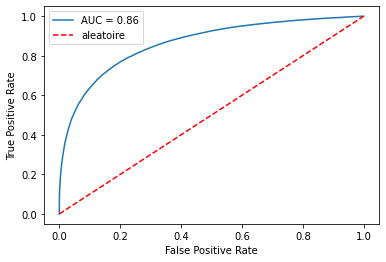

In [ ]:
y_preds_test = lr_balanced.predict_proba(X_test)
fpr_test, tpr_test, seuils_test = roc_curve(y_test, y_preds_test[:, 1], pos_label=1)

roc_auc_test = auc(fpr_test, tpr_test)
r = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test)
r.plot()
plt.plot([0, 1], [0, 1], "r--", label="aleatoire")

plt.legend()
plt.show()

In [ ]:
# test en abaissant le seuil à 0.19 (et non plus 0.5 par defaut)

In [ ]:
y_preds_test = lr_balanced.predict_proba(X_test)
y_preds_test = np.where(y_preds_test[:, 1] > 0.19, 1, 0)
print(pd.crosstab(y_test, y_preds_test))
print(classification_report_imbalanced(y_test, y_preds_test))

col_0      0      1
Goal               
0      27717  39353
1       2213  40216
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.41      0.95      0.57      0.63      0.37     67070
          1       0.51      0.95      0.41      0.66      0.63      0.41     42429

avg / total       0.76      0.62      0.74      0.61      0.63      0.39    109499



In [ ]:
# optimisation du modèle de Logistic Regression

In [ ]:
def objective(trial):

    params = {
        "tol": trial.suggest_uniform("tol", 1e-6, 1e-3),
        "C": trial.suggest_loguniform("C", 1e-2, 1),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"]),
        "n_jobs": -1,
    }
    model1 = LogisticRegression(**params, class_weight="balanced", random_state=42)
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    score = recall_score(y_test, y_pred)

    return score


study = optuna.create_study(
    direction="maximize", study_name="lr", pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=100, reduction_factor=3)
    
)
study.optimize(objective, n_trials=20)
print("numbers of the finished trials:", len(study.trials))
print("the best params:", study.best_trial.params)
print("the best value:", study.best_value)

[I 2022-06-03 08:07:40,277] A new study created in memory with name: lr
[I 2022-06-03 08:13:10,937] Trial 0 finished with value: 0.7612717716656061 and parameters: {'tol': 0.0008379181672425956, 'C': 0.12960916989385485, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7612717716656061.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
[I 2022-06-03 08:13:26,248] Trial 1 finished with value: 0.7612010653091046 and parameters: {'tol': 0.00045471320604190265, 'C': 0.16013013437641013, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7612717716656061.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
[I 2022-06-03 08:13:38,886] Trial 2 finished with value: 0.7611303589526032 and parameters: {'tol': 5.42957256318223e-05, 'C': 0.023928386584522468, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7612717716656061.
'n_jobs' > 1 

numbers of the finished trials: 20
the best params: {'tol': 0.0008269447664674287, 'C': 0.4037181067888838, 'fit_intercept': True, 'solver': 'liblinear'}
the best value: 0.7612953404511066


In [ ]:
param = study.best_trial.params

lr_optuna = LogisticRegression(**param, class_weight="balanced", random_state=42)
Cross(lr_optuna, "recall")


 Résultat de la Cross Validation:
[0.7519685  0.73974306 0.75238293 0.77331123 0.77597537]
0.758676218104316
 
 Matrice de confusion:
col_0      0      1
Goal               
0      54142  12928
1      10128  32301

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.81      0.76      0.82      0.78      0.62     67070
          1       0.71      0.76      0.81      0.74      0.78      0.61     42429

avg / total       0.79      0.79      0.78      0.79      0.78      0.62    109499



(LogisticRegression(C=0.4037181067888838, class_weight='balanced',
                    random_state=42, solver='liblinear',
                    tol=0.0008269447664674287), array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
# 2e essai: avec une classifier Stochastic

In [ ]:
sg = SGDClassifier(class_weight="balanced", random_state=42)
model, y_pred = Cross(sg, "recall")


 Résultat de la Cross Validation:
[0.80933633 0.79231543 0.80599136 0.82564679 0.74800189]
0.7962583624415369
 
 Matrice de confusion:
col_0      0      1
Goal               
0      52493  14577
1       9291  33138

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.78      0.78      0.81      0.78      0.61     67070
          1       0.69      0.78      0.78      0.74      0.78      0.61     42429

avg / total       0.79      0.78      0.78      0.78      0.78      0.61    109499



In [ ]:
# courbe precision-rappel

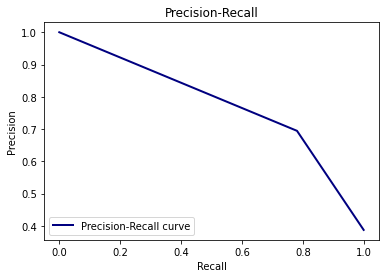

In [ ]:
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())

lw = 2

plt.plot(recall, precision, lw=lw, color="navy", label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.title("Precision-Recall")
plt.legend(loc="lower left");

In [ ]:
# Optimisation du SGDClassifier:

In [ ]:
def objective(trial):

    params = {
        "alpha": trial.suggest_loguniform("alpha", 0.0001, 0.01),
        "loss": trial.suggest_categorical("loss", ["hinge", "modified_huber"]),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
    }
    model1 = SGDClassifier(**params, class_weight="balanced", random_state=42)
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    score = recall_score(y_test, y_pred)

    return score


study = optuna.create_study(
    direction="maximize", study_name="sgdc", pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=50)
print("numbers of the finished trials:", len(study.trials))
print("the best params:", study.best_trial.params)
print("the best value:", study.best_value)

[I 2022-06-02 11:03:16,160] A new study created in memory with name: sgdc
[I 2022-06-02 11:03:29,734] Trial 0 finished with value: 0.7435480449692428 and parameters: {'alpha': 0.0009725549938344934, 'loss': 'modified_huber', 'penalty': 'l2'}. Best is trial 0 with value: 0.7435480449692428.
[I 2022-06-02 11:03:42,476] Trial 1 finished with value: 0.7288411228169412 and parameters: {'alpha': 0.00015441026634707252, 'loss': 'hinge', 'penalty': 'l1'}. Best is trial 0 with value: 0.7435480449692428.
[I 2022-06-02 11:03:55,415] Trial 2 finished with value: 0.7431473756157345 and parameters: {'alpha': 0.0009455529695791786, 'loss': 'modified_huber', 'penalty': 'l2'}. Best is trial 0 with value: 0.7435480449692428.
[I 2022-06-02 11:04:09,530] Trial 3 finished with value: 0.7786891041504631 and parameters: {'alpha': 0.004179651526002092, 'loss': 'modified_huber', 'penalty': 'l1'}. Best is trial 3 with value: 0.7786891041504631.
[I 2022-06-02 11:04:16,882] Trial 4 finished with value: 0.74413726

numbers of the finished trials: 50
the best params: {'alpha': 0.0010782085713272802, 'loss': 'modified_huber', 'penalty': 'l2'}
the best value: 0.7951872540008014


In [ ]:
sgd_optuna = SGDClassifier(
    **study.best_trial.params, class_weight="balanced", random_state=42
)
Cross(sgd_optuna, "recall")


 Résultat de la Cross Validation:
[0.799183   0.74971879 0.76765733 0.79533479 0.83787224]
0.7899532295305192
 
 Matrice de confusion:
col_0      0      1
Goal               
0      51345  15725
1       8690  33739

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.77      0.80      0.81      0.78      0.61     67070
          1       0.68      0.80      0.77      0.73      0.78      0.61     42429

avg / total       0.79      0.78      0.78      0.78      0.78      0.61    109499



(SGDClassifier(alpha=0.0010782085713272802, class_weight='balanced',
               loss='modified_huber', random_state=42),
 array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
xgbC = XGBClassifier()
Cross(xgbC, "recall")


 Résultat de la Cross Validation:
[0.6722811  0.65156    0.66899532 0.67846782 0.69267657]
0.6727961636374401
 
 Matrice de confusion:
col_0      0      1
Goal               
0      59418   7652
1      13553  28876

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.89      0.68      0.85      0.78      0.62     67070
          1       0.79      0.68      0.89      0.73      0.78      0.59     42429

avg / total       0.81      0.81      0.76      0.80      0.78      0.61    109499



(XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, ...), array([0, 0, 0, ..., 0, 0, 1]))

In [ ]:
l_svc = LinearSVC(class_weight="balanced", random_state=42)

In [ ]:
Cross(l_svc, "recall")

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.



 Résultat de la Cross Validation:
[0.7442425  0.73317151 0.74669943 0.7727192  0.77041028]
0.7534485820851341


Liblinear failed to converge, increase the number of iterations.


 
 Matrice de confusion:
col_0      0      1
Goal               
0      54577  12493
1      10445  31984

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.81      0.75      0.83      0.78      0.62     67070
          1       0.72      0.75      0.81      0.74      0.78      0.61     42429

avg / total       0.79      0.79      0.78      0.79      0.78      0.61    109499



(LinearSVC(class_weight='balanced', random_state=42),
 array([0, 0, 0, ..., 0, 1, 1]))

In [ ]:
def objective(trial):

    params = {
        "tol": trial.suggest_uniform("tol", 1e-6, 1e-3),
        "C": trial.suggest_loguniform("C", 9, 50),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
    }

    model1 = LinearSVC(**params, class_weight="balanced", dual=False, random_state=42)
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    score = recall_score(y_test, y_pred)

    return score


study = optuna.create_study(
    direction="maximize", study_name="l_svc", pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=20)
print("numbers of the finished trials:", len(study.trials))
print("the best params:", study.best_trial.params)
print("the best value:", study.best_value)

[I 2022-06-02 13:48:07,988] A new study created in memory with name: l_svc
[I 2022-06-02 13:48:27,128] Trial 0 finished with value: 0.7558273822149945 and parameters: {'tol': 0.0007400900649742774, 'C': 31.556486676073245, 'fit_intercept': False, 'penalty': 'l2'}. Best is trial 0 with value: 0.7558273822149945.
[I 2022-06-02 13:48:38,002] Trial 1 finished with value: 0.7558980885714959 and parameters: {'tol': 0.00039562164791340297, 'C': 15.156512485087013, 'fit_intercept': False, 'penalty': 'l1'}. Best is trial 1 with value: 0.7558980885714959.
[I 2022-06-02 13:48:46,019] Trial 2 finished with value: 0.7558273822149945 and parameters: {'tol': 0.0009875465300578155, 'C': 9.451728562639717, 'fit_intercept': True, 'penalty': 'l1'}. Best is trial 1 with value: 0.7558980885714959.
[I 2022-06-02 13:49:11,746] Trial 3 finished with value: 0.7558980885714959 and parameters: {'tol': 7.533096617587569e-05, 'C': 41.22921560150462, 'fit_intercept': False, 'penalty': 'l2'}. Best is trial 1 with va

numbers of the finished trials: 20
the best params: {'tol': 0.00039562164791340297, 'C': 15.156512485087013, 'fit_intercept': False, 'penalty': 'l1'}
the best value: 0.7558980885714959


In [ ]:
param = study.best_trial.params

l_svc_optuna = LinearSVC(**param,class_weight="balanced", random_state=42)
Cross(l_svc_optuna, "recall")

In [ ]:
# meilleur algo: sgdclassifier avec optuna

In [ ]:
#sauvegarde du modèle
#dump(
    #sgd_optuna,
    #"/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_target_360/sgd_optuna.joblib",
    #compress=9,
#)

['/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_target_360/sgd_optuna.joblib']

In [ ]:
#chargement du modèle
#sgd_optuna = load(
    #"/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_target_360/sgd_optuna.joblib"
#)

In [ ]:
y_pred=sgd_optuna.predict(X_test)
y_test_pred=pd.Series(y_pred,index=y_test.index)

In [ ]:
#sauvegarde de y_test_pred contenant les predictions de y_test pour comparaison avec le modèle de régression
y_test_pred.to_pickle('/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_target_360/y_pred.pkl')

                                                 coeff
Distance                                      0.759093
AddressQualifier_On motorway / elevated road  0.308666
Station_Code_of_ressource_G29                 0.253844
Station_Code_of_ressource_H33                -0.245198
Station_Code_of_ressource_F38                -0.237659
IncidentStationGround_Code_H41               -0.230876
Station_Code_of_ressource_G39                -0.221151
Station_Code_of_ressource_A36                -0.212711
IncidentStationGround_Code_A24                0.212197
Station_Code_of_ressource_H24                -0.203039




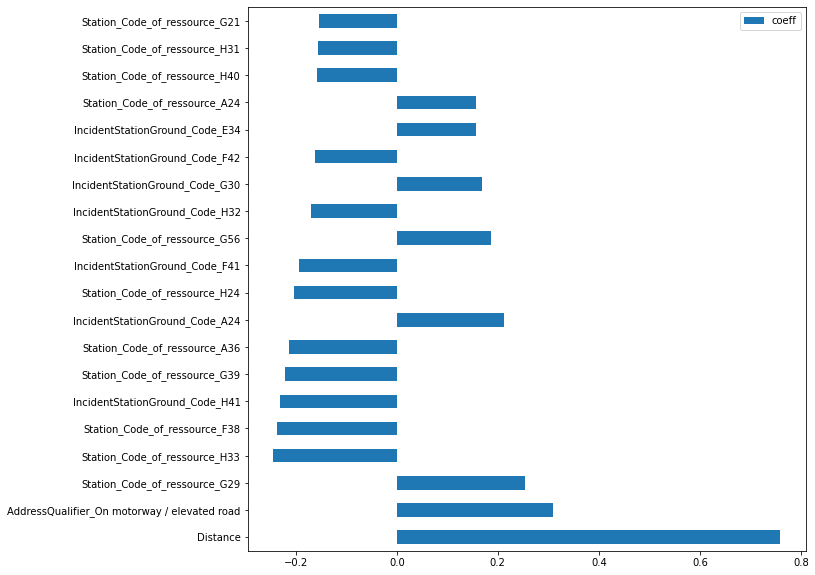

In [ ]:
#graphique des features selon leurs importances (filtre sur les 10 plus significatives)
plot_bar(sgd_optuna)

In [ ]:
explainer = shap.LinearExplainer(sgd_optuna, X_train)
shap_values = explainer.shap_values(X_test)
preds = sgd_optuna.predict(X_test)

In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[1]))
print("Model's prediction: {}".format(preds[1]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :])

Test data (actual observation): 0
Model's prediction: 0


In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[19]))
print("Model's prediction: {}".format(preds[19]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[19, :], X_test.iloc[19, :])

Test data (actual observation): 0
Model's prediction: 0


In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[54784]))
print("Model's prediction: {}".format(preds[54784]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[54784, :], X_test.iloc[54784, :])

Test data (actual observation): 1
Model's prediction: 1


In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[5000]))
print("Model's prediction: {}".format(preds[5000]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5000, :], X_test.iloc[5000, :])

Test data (actual observation): 1
Model's prediction: 0


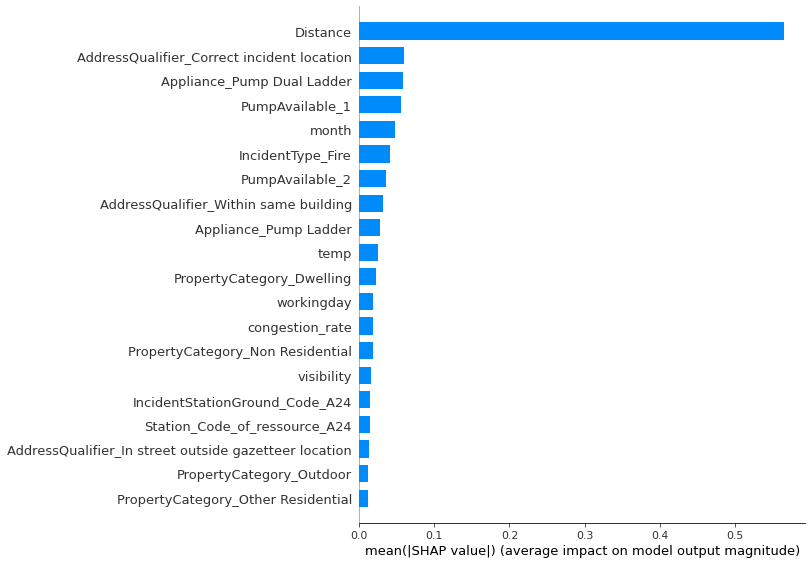

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

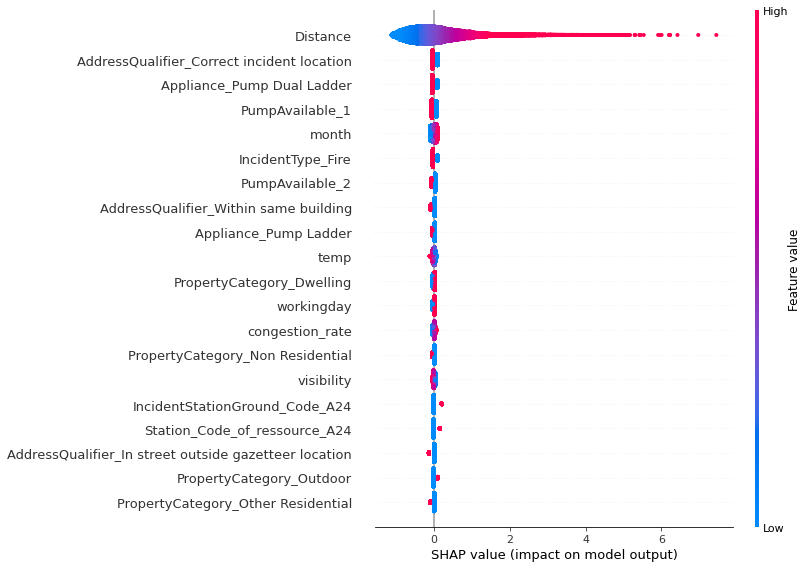

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In [ ]:
# Verification si meilleur model avec un outil automatisé de recherche d'algo: Tpot

In [ ]:
tpot = TPOTClassifier(
    generations=5,
    population_size=50,
    verbosity=2,
    scoring="recall",
    config_dict="TPOT light",
    max_time_mins=360,
)

tpt = tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7563021727547216

Generation 2 - Current best internal CV score: 0.7815049434610147

Generation 3 - Current best internal CV score: 0.7815049434610147

Generation 4 - Current best internal CV score: 0.7815049434610147


In [ ]:
# avec un recall à 0.78, le modèle trouvé par Tpot est en deçà de notre SGDClassifier optimisé